In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [63]:
# coding:utf-8
# https://blog.keras.io/building-autoencoders-in-keras.html
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.metrics import binary_crossentropy


latent_dim = 2
epsilon_std = 1.0
intermediate_dim = 512
batch_size = 16


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon


def vae_loss(x, x_decoded_mean):
    reconst_loss = binary_crossentropy(x,z_)
    latent_loss =  - 0.5 * K.mean(K.sum(1 + K.log(K.square(z_sigma)) - K.square(z_mean) - K.square(z_sigma), axis=-1))
    return reconst_loss + latent_loss



x = Input(batch_shape=(batch_size, 784))
h = Dense(intermediate_dim, activation='relu')(x)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(784, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


vae = Model(x, x_decoded_mean)
encoder = Model(x, z_mean)

decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)


vae.compile(optimizer='adam', loss=vae_loss)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


NameError: name 'z_' is not defined

In [65]:
epochs=100
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

RuntimeError: You must compile your model before using it.

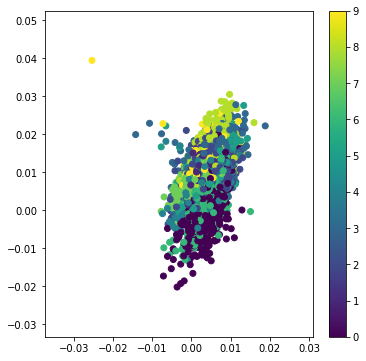

In [55]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

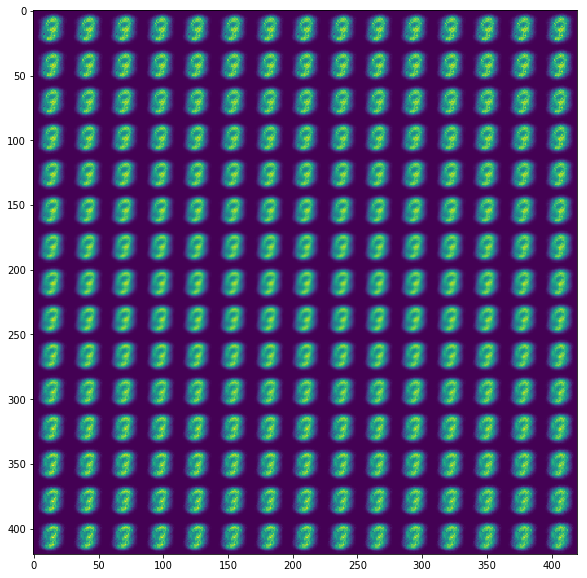

In [56]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [61]:
import numpy
from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend, metrics
from keras.datasets import mnist

# 2次元正規分布から1点サンプリングする補助関数です
def sampling(args):
  z_mean, z_log_var = args
  epsilon = backend.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=epsilon_std)
  return z_mean + backend.exp(z_log_var / 2) * epsilon

# Keras の Layer クラスを継承してオリジナルの損失関数を付加するレイヤーをつくります
class CustomVariationalLayer(Layer):
  def __init__(self, **kwargs):
    self.is_placeholder = True
    super(CustomVariationalLayer, self).__init__(**kwargs)

  def vae_loss(self, x, x_decoded_mean): # オリジナルの損失関数
    # 入力と出力の交差エントロピー
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) 
    # 事前分布と事後分布のKL情報量
    kl_loss = - 0.5 * backend.sum(1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var), axis=-1)
    return backend.mean(xent_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    x_decoded_mean = inputs[1]
    loss = self.vae_loss(x, x_decoded_mean)
    self.add_loss(loss, inputs=inputs) # オリジナルの損失関数を付加
    return x # この自作レイヤーの出力を一応定義しておきますが、今回この出力は全く使いません

if __name__ == "__main__":
  batch_size = 100
  original_dim = 784
  latent_dim = 2
  intermediate_dim = 256
  epochs = 10
  epsilon_std = 1.0

  #============================================================
  # 変分自己符号化器を構築します

  # エンコーダ
  x = Input(batch_shape=(batch_size, original_dim))
  h = Dense(intermediate_dim, activation='relu')(x)
  z_mean = Dense(latent_dim)(h)
  z_log_var = Dense(latent_dim)(h)
  z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

  # デコーダ
  decoder_h = Dense(intermediate_dim, activation='relu')
  decoder_mean = Dense(original_dim, activation='sigmoid')
  h_decoded = decoder_h(z)
  x_decoded_mean = decoder_mean(h_decoded)

  # カスタマイズした損失関数を付加する訓練用レイヤー
  y = CustomVariationalLayer()([x, x_decoded_mean])
  vae = Model(x, y)
  vae.compile(optimizer='rmsprop', loss=None)

  #============================================================
  # モデルを訓練します

  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = x_train.astype('float32') / 255.
  x_test = x_test.astype('float32') / 255.
  x_train = x_train.reshape((len(x_train), numpy.prod(x_train.shape[1:])))
  x_test = x_test.reshape((len(x_test), numpy.prod(x_test.shape[1:])))
  vae.fit(x_train, shuffle=True, epochs=epochs, batch_size=batch_size,
          validation_data=(x_test, x_test))

  #============================================================
  # 結果を表示します

  # (1) 隠れ変数空間のプロット（エンコードした状態のプロット）
  encoder = Model(x, z_mean) # エンコーダのみ分離
  x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
  plt.figure(figsize=(6, 6))
  plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
  plt.colorbar()
  plt.show()

  # (2) 隠れ変数空間からサンプリングした点がどんな手書き数字を生成するか（どうデコードされるか）をプロット
  decoder_input = Input(shape=(latent_dim,))
  _h_decoded = decoder_h(decoder_input)
  _x_decoded_mean = decoder_mean(_h_decoded)
  generator = Model(decoder_input, _x_decoded_mean) # デコーダのみ分離

  n = 15  # 15x15 個の手書き数字をプロットする
  digit_size = 28
  figure = numpy.zeros((digit_size * n, digit_size * n))
  grid_x = numpy.linspace(-15, 15, n)
  grid_y = numpy.linspace(-15, 15, n)

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z_sample = numpy.array([[xi, yi]])
      x_decoded = generator.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[i * digit_size: (i + 1) * digit_size,
             j * digit_size: (j + 1) * digit_size] = digit

  plt.figure(figsize=(10, 10))
  plt.imshow(figure)
  plt.show()

ValueError: ('Error when checking model target: expected no data, but got:', array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

# 